<a href="https://colab.research.google.com/github/ravellys/NLP_coursera/blob/main/Semana02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
#import dataser
import tensorflow_datasets as tfds
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [ ]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

# função para extrair dados de sentence e label do data_set imdb
def sentences_labels(data):
  sentences = []
  labels = []
  for s, l in data:
    sentences.append(s.numpy().decode('utf8'))
    labels.append(l.numpy())
  return sentences, np.array(labels)

training_sentences, training_labels_final = sentences_labels(train_data)
testing_sentences, testing_labels_final = sentences_labels(test_data)

In [ ]:
print(f"está é uma sentença:{training_sentences[0]}")
print(f"está é sua label: {training_labels_final[0]}")

está é uma sentença:This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
está é sua label: 0


In [ ]:
# parametros iniciais
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<00v>"

In [ ]:
# preparação dos dados / tranformando sentenças em vetores
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def padded_data(vocab_size, training_sentences, testing_sentences, max_length, trunc_type):
  tokenizer = Tokenizer(num_words=vocab_size)
  tokenizer.fit_on_texts(training_sentences)
  word_index = tokenizer.word_index

  sequences = tokenizer.texts_to_sequences(training_sentences)
  padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

  return padded, testing_padded, tokenizer

padded, testing_padded, tokenizer = padded_data(vocab_size, training_sentences, testing_sentences, max_length, trunc_type)

In [ ]:
# comparação de dados reais e dados processados

reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you into a big arm chair and for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no to cross no dangerous waters just a warm and witty through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')                           
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 10
model.fit(x=padded,
          y=training_labels_final,
          epochs=num_epochs,
          validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 4s 5ms/step - loss: 0.5386 - accuracy: 0.7370 - val_loss: 0.3668 - val_accuracy: 0.8532
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 0.3011 - accuracy: 0.8862 - val_loss: 0.3357 - val_accuracy: 0.8586
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1993 - accuracy: 0.9360 - val_loss: 0.3660 - val_accuracy: 0.8491
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1200 - accuracy: 0.9701 - val_loss: 0.4019 - val_accuracy: 0.8434
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0670 - accuracy: 0.9879 - val_loss: 0.4496 - val_accuracy: 0.8396
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0382 - accuracy: 0.9943 - val_loss: 0.4988 - val_accuracy: 0.8335
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0235 - accuracy: 0.9969 - val_loss: 0.5423 - val_accuracy: 0.8309
Epoch 

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[10, 63, 101, 11, 6, 477, 1199]]


# Lesson 2


In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass  

In [ ]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [ ]:
# Dados Iniciais
vocab_size = 1000
embedding_dim = 16
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-11-13 01:12:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.04s   

2020-11-13 01:12:31 (121 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
training_sequences[0]

[328, 1, 799, 1, 1, 47, 389, 1, 1, 6, 1, 1]

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 16)            16000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
history = model.fit(training_padded,
                    np.array(training_labels),
                    epochs=num_epochs,
                    validation_data=(testing_padded, np.array(testing_labels)))

Epoch 1/30
625/625 [==============================] - 1s 2ms/step - loss: 0.5277 - accuracy: 0.7336 - val_loss: 0.4124 - val_accuracy: 0.8053
Epoch 2/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3801 - accuracy: 0.8245 - val_loss: 0.3991 - val_accuracy: 0.8111
Epoch 3/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3627 - accuracy: 0.8331 - val_loss: 0.4006 - val_accuracy: 0.8153
Epoch 4/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3579 - accuracy: 0.8376 - val_loss: 0.4002 - val_accuracy: 0.8119
Epoch 5/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3544 - accuracy: 0.8396 - val_loss: 0.4022 - val_accuracy: 0.8101
Epoch 6/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3526 - accuracy: 0.8396 - val_loss: 0.4047 - val_accuracy: 0.8131
Epoch 7/30
625/625 [==============================] - 1s 1ms/step - loss: 0.3517 - accuracy: 0.8407 - val_loss: 0.4101 - val_accuracy: 0.8123
Epoch 

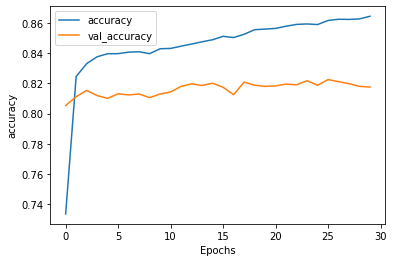

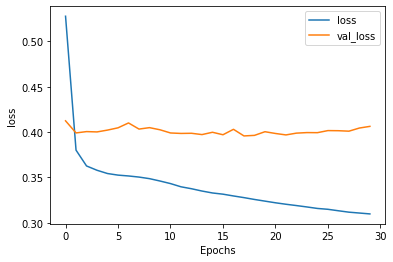

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])

  plt.savefig(string+'.png')
  plt.show()

  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store <OOV> <OOV> over secret <OOV> <OOV> for <OOV> <OOV> ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(1000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.39352304]
 [0.5094867 ]]


# Lesson 3

In [ ]:
# Double check TF 2.0x is installed. If you ran the above block, there was a 
# 'reset all runtimes' button at the bottom that you needed to press
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
# If the import fails, run this
# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJLCBK9/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJLCBK9/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteJLCBK9/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [ ]:
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [ ]:
sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}'.format(original_string))


Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [ ]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [ ]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 2

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/2
391/391 [==============================] - 16s 41ms/step - loss: 0.6768 - accuracy: 0.5808 - val_loss: 0.6275 - val_accuracy: 0.7150
Epoch 2/2
391/391 [==============================] - 16s 40ms/step - loss: 0.4977 - accuracy: 0.8206 - val_loss: 0.4152 - val_accuracy: 0.8444


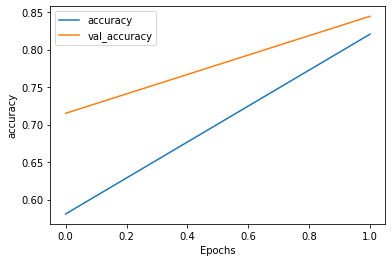

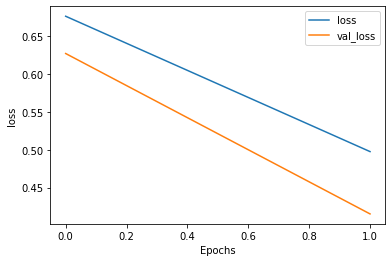

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

# Exercício


In [10]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv

--2020-11-13 12:56:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 172.217.212.128, 172.217.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2020-11-13 12:56:48 (113 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [12]:
vocab_size = 1000# YOUR CODE HERE
embedding_dim = 16# YOUR CODE HERE
max_length = 120# YOUR CODE HERE
trunc_type = 'post'# YOUR CODE HERE
padding_type = 'post'# YOUR CODE HERE
oov_tok = '<OOV>'# YOUR CODE HERE
training_portion = .8

In [13]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))
# Expected Output
# 153

153


In [14]:
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)
    
print(len(labels))
print(len(sentences))
print(sentences[0])
# Expected Output
# 2225
# 2225
# tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us networks cable satellite companies worried means terms advertising revenues well  brand identity  viewer loyalty channels. although us leads technology moment  also concern raised europe  particularly growing uptake services like sky+.  happens today  will see nine months years  time uk   adam hume  bbc broadcast s futurologist told bbc news website. likes bbc  no issues lost advertising revenue yet. pressing issue moment commercial uk broadcasters  brand loyalty important everyone.  will talking content brands rather network brands   said tim hanlon  brand communications firm starcom mediavest.  reality broadband connections  anybody can producer content.  added:  challenge now hard promote programme much choice.   means  said stacey jolna  senior vice president tv guide tv group  way people find content want watch simplified tv viewers. means networks  us terms  channels take leaf google s book search engine future  instead scheduler help people find want watch. kind channel model might work younger ipod generation used taking control gadgets play them. might not suit everyone  panel recognised. older generations comfortable familiar schedules channel brands know getting. perhaps not want much choice put hands  mr hanlon suggested.  end  kids just diapers pushing buttons already - everything possible available   said mr hanlon.  ultimately  consumer will tell market want.   50 000 new gadgets technologies showcased ces  many enhancing tv-watching experience. high-definition tv sets everywhere many new models lcd (liquid crystal display) tvs launched dvr capability built  instead external boxes. one example launched show humax s 26-inch lcd tv 80-hour tivo dvr dvd recorder. one us s biggest satellite tv companies  directtv  even launched branded dvr show 100-hours recording capability  instant replay  search function. set can pause rewind tv 90 hours. microsoft chief bill gates announced pre-show keynote speech partnership tivo  called tivotogo  means people can play recorded programmes windows pcs mobile devices. reflect increasing trend freeing multimedia people can watch want  want.

2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertai

In [15]:
train_size = int(training_portion*len(sentences))# YOUR CODE HERE

train_sentences = sentences[:train_size] # YOUR CODE HERE
train_labels = labels[:train_size] # YOUR CODE HERE

validation_sentences = sentences[train_size:]  # YOUR CODE HERE
validation_labels = labels[train_size:] # YOUR CODE HERE

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

# Expected output (if training_portion=.8)
# 1780
# 1780
# 1780
# 445
# 445

1780
1780
1780
445
445


In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok) # YOUR CODE HERE
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index# YOUR CODE HERE

train_sequences = tokenizer.texts_to_sequences(train_sentences)# YOUR CODE HERE
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)# YOUR CODE HERE

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

# Expected Ouput
# 449
# 120
# 200
# 120
# 192
# 120

449
120
200
120
192
120


In [18]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)# YOUR CODE HERE
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)# YOUR CODE HERE

print(len(validation_sequences))
print(validation_padded.shape)

# Expected output
# 445
# (445, 120)

445
(445, 120)


In [24]:
label_tokenizer = Tokenizer()# YOUR CODE HERE
label_tokenizer.fit_on_texts(labels)# YOUR CODE HERE)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))# YOUR CODE HERE
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))# YOUR CODE HERE

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [31]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
])



model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 16,558
Trainable params: 16,558
Non-trainable params: 0
_________________________________________________________________


In [32]:
num_epochs = 30
history = model.fit(
    x=train_padded,
    y=training_label_seq,
    epochs=num_epochs,
    validation_data=(validation_padded, validation_label_seq),
    verbose=2    
)

Epoch 1/30
56/56 - 0s - loss: 1.7642 - acc: 0.2685 - val_loss: 1.7310 - val_acc: 0.2449
Epoch 2/30
56/56 - 0s - loss: 1.6829 - acc: 0.2798 - val_loss: 1.6321 - val_acc: 0.3888
Epoch 3/30
56/56 - 0s - loss: 1.5581 - acc: 0.4348 - val_loss: 1.4850 - val_acc: 0.4360
Epoch 4/30
56/56 - 0s - loss: 1.3787 - acc: 0.4607 - val_loss: 1.2898 - val_acc: 0.4989
Epoch 5/30
56/56 - 0s - loss: 1.1640 - acc: 0.6034 - val_loss: 1.0848 - val_acc: 0.6697
Epoch 6/30
56/56 - 0s - loss: 0.9534 - acc: 0.7854 - val_loss: 0.8956 - val_acc: 0.8202
Epoch 7/30
56/56 - 0s - loss: 0.7681 - acc: 0.8938 - val_loss: 0.7490 - val_acc: 0.8382
Epoch 8/30
56/56 - 0s - loss: 0.6217 - acc: 0.9236 - val_loss: 0.6265 - val_acc: 0.8854
Epoch 9/30
56/56 - 0s - loss: 0.5081 - acc: 0.9427 - val_loss: 0.5332 - val_acc: 0.9056
Epoch 10/30
56/56 - 0s - loss: 0.4166 - acc: 0.9500 - val_loss: 0.4577 - val_acc: 0.9079
Epoch 11/30
56/56 - 0s - loss: 0.3402 - acc: 0.9607 - val_loss: 0.3978 - val_acc: 0.9101
Epoch 12/30
56/56 - 0s - loss:

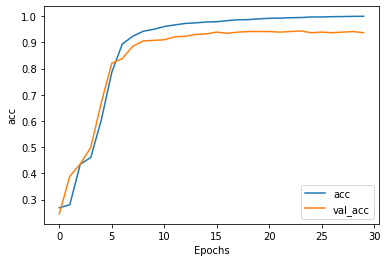

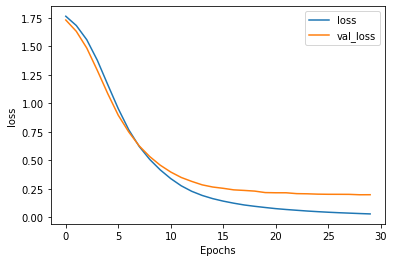

In [33]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [34]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


In [35]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(1000, 16)


In [36]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [37]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>